In [1]:
import pandas as pd
import missingno as msn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
pred_df = test_data[['User_ID', 'Product_ID']]
train_data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


# EDA

### Missing value detection

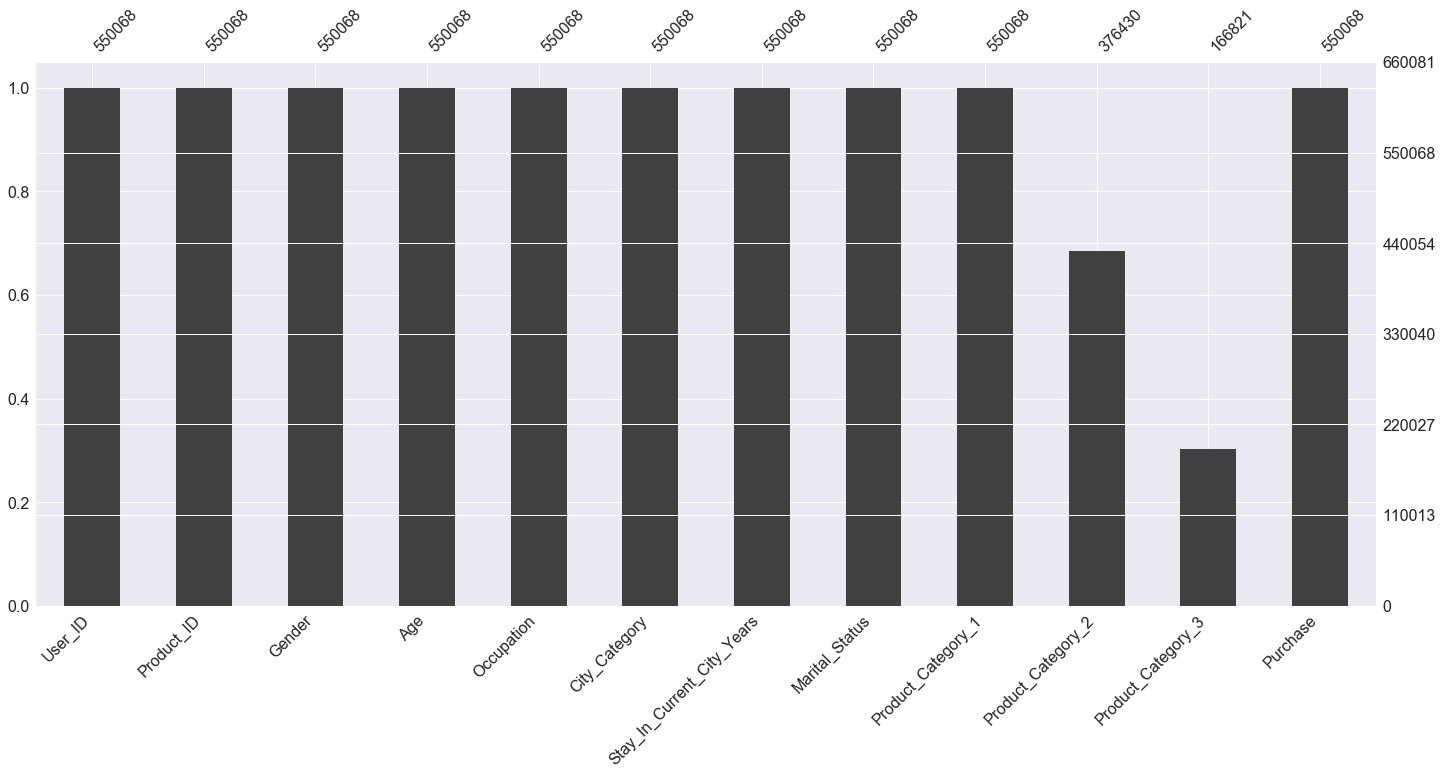

In [3]:
msn.bar(train_data)

### Univariate analysis

In [4]:
train_data['Age'].unique() #We can observe the value '55+' which will give us a problem later

array(['0-17', '55+', '26-35', '46-50', '51-55', '36-45', '18-25'], dtype=object)

In [5]:
train_data['Occupation'].unique()

array([10, 16, 15,  7, 20,  9,  1, 12, 17,  0,  3,  4, 11,  8, 19,  2, 18,
        5, 14, 13,  6], dtype=int64)

In [6]:
train_data['Stay_In_Current_City_Years'].unique()

array(['2', '4+', '3', '1', '0'], dtype=object)

### Bivariate analysis

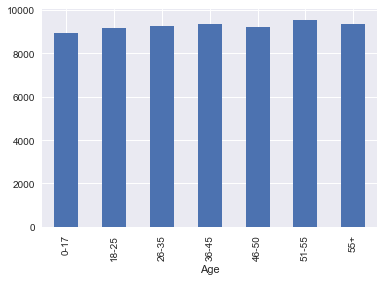

In [7]:
train_data.groupby('Age')['Purchase'].mean().plot(kind = 'bar')

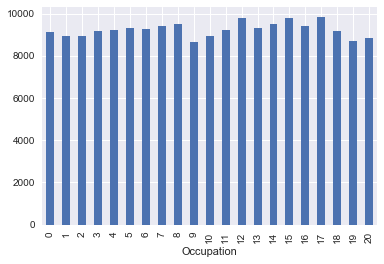

In [8]:
train_data.groupby('Occupation')['Purchase'].mean().plot(kind = 'bar')

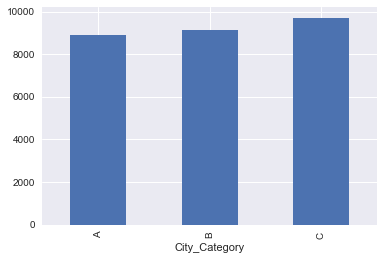

In [9]:
train_data.groupby('City_Category')['Purchase'].mean().plot(kind = 'bar')

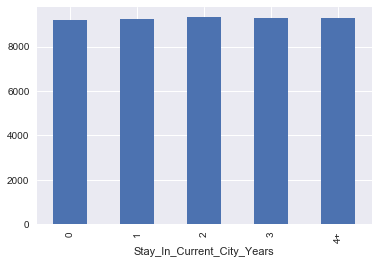

In [10]:
train_data.groupby('Stay_In_Current_City_Years')['Purchase'].mean().plot(kind = 'bar') # We can observe that this variable 
                                                                                       # has no effect on the target variable.

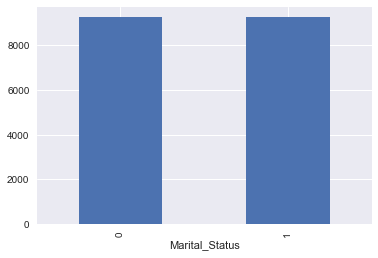

In [11]:
train_data.groupby('Marital_Status')['Purchase'].mean().plot(kind = 'bar') # We can observe that this variable has no effect
                                                                           # on the target variable.

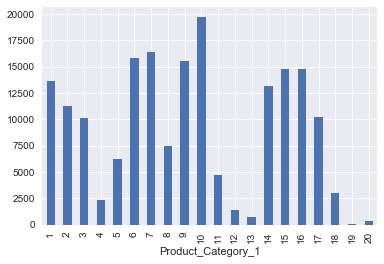

In [12]:
train_data.groupby('Product_Category_1')['Purchase'].mean().plot(kind = 'bar')

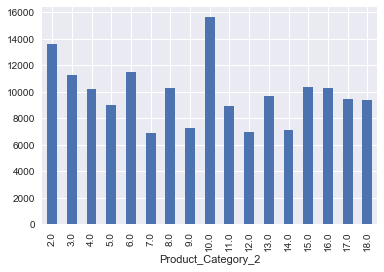

In [13]:
train_data.groupby('Product_Category_2')['Purchase'].mean().plot(kind = 'bar')

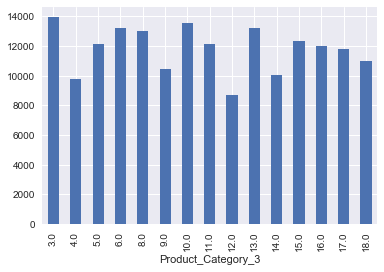

In [14]:
train_data.groupby('Product_Category_3')['Purchase'].mean().plot(kind = 'bar')

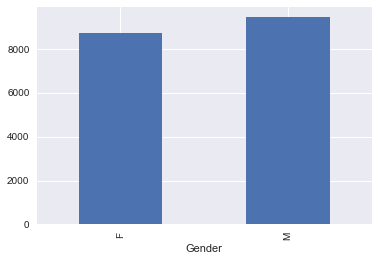

In [15]:
train_data.groupby('Gender')['Purchase'].mean().plot(kind = 'bar')

# Feature engineering:

In [16]:
def feature_engineering(df):
    
    # Missing value imputation
    df['Product_Category_2'].fillna(0, inplace = True)
    df['Product_Category_3'].fillna(0, inplace = True)
    
    # Encoding of categorical variables
    df['City_Category'].replace(['A', 'B', 'C'], [1, 2, 3], inplace = True)
    df['Gender'].replace(['F', 'M'], [1, 2], inplace = True)
    df['Age'].replace(['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'],
                             [1, 2, 4, 5, 3, 7, 6], inplace =True)
    df['Stay_In_Current_City_Years'].replace('4+', 4, inplace = True)
    
    # Dropping the columns deemed unnecessary
    df.drop(['User_ID', 'Product_ID', 'Marital_Status'], axis = 1, inplace = True)
    
    return df

train_data = feature_engineering(train_data)

# The following lines use the relation between categorical variables and taret variable to encode them.
values_pc1 = train_data.groupby('Product_Category_1')['Purchase'].mean().sort_values(ascending = True).index
train_data['Product_Category_1'].replace(values_pc1, range(1, len(values_pc1) + 1), inplace = True)

values_pc2 = train_data.groupby('Product_Category_2')['Purchase'].mean().sort_values(ascending = True).index
train_data['Product_Category_2'].replace(values_pc2, range(1, len(values_pc2) + 1), inplace = True)

values_pc3 = train_data.groupby('Product_Category_3')['Purchase'].mean().sort_values(ascending = True).index
train_data['Product_Category_3'].replace(values_pc3, range(1, len(values_pc3) + 1), inplace = True)

values_o = train_data.groupby('Occupation')['Purchase'].mean().sort_values(ascending = True).index
train_data['Occupation'].replace(values_o, range(1, len(values_o) + 1), inplace = True)

values_a = train_data.groupby('Age')['Purchase'].mean().sort_values(ascending = True).index
train_data['Age'].replace(values_a, range(1, len(values_a) + 1), inplace = True)

test_data = feature_engineering(test_data)

# Realtion of the categorical variables to target variable in train data is used in test data
test_data['Product_Category_1'].replace(values_pc1, range(1, len(values_pc1) + 1), inplace = True)
test_data['Product_Category_2'].replace(values_pc2, range(1, len(values_pc2) + 1), inplace = True)
test_data['Product_Category_3'].replace(values_pc3, range(1, len(values_pc3) + 1), inplace = True)
test_data['Age'].replace(values_a, range(1, len(values_a) + 1), inplace = True)
test_data['Occupation'].replace(values_o, range(1, len(values_o) + 1), inplace = True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:,0:8], 
                                                    train_data.iloc[:,8], 
                                                    test_size=0.2, 
                                                    random_state=42)

# Iteration 1: Using Lasso regression

In [18]:
clf = Lasso(alpha = 1.0)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
math.sqrt(mean_squared_error(y_test, prediction))

3084.879056823785

In [19]:
# test_prediction = clf.predict(test_data)
# pred_df['Purchase'] = test_prediction
# pred_df.to_csv("./black_friday.csv")

# Iteration 2: Using Ridge regression

In [20]:
clf = Ridge(alpha = 1)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
math.sqrt(mean_squared_error(y_test, prediction))

3084.8802119498187

In [21]:
# test_prediction = clf.predict(test_data)
# pred_df['Purchase'] = test_prediction
# pred_df.to_csv("./black_friday.csv")

# Iteration 3: Using Random forest regressor

In [22]:
clf = RandomForestRegressor(oob_score = True,
                            random_state = 42
                           )

parameters = {'n_estimators': [32], 
              'max_features': ['auto'], 
              'criterion': ['mse'],
              'max_depth': [5], 
              'min_samples_split': [2],
              'min_samples_leaf': [9]
             }
grid_search = GridSearchCV(clf, parameters)
grid_search.fit(X_train, y_train)
clf = grid_search.best_estimator_
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
math.sqrt(mean_squared_error(y_test, prediction))

3029.906370454771

In [23]:
# test_prediction = clf.predict(test_data)
# pred_df['Item_Outlet_Sales'] = test_prediction
# pred_df.to_csv("./black_friday.csv")

In [24]:
grid_search.best_params_

{'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 9,
 'min_samples_split': 2,
 'n_estimators': 32}